In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas Options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

#Set Seaborn Theme
sns.set_style('darkgrid')

# Used ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__` WHERE table_id IN ('census_block',
'fcc_demography', 'blockgroup_2016_relevant_group1', 'laws_against_municipal_broadband') 
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

tables.sort_values('row_count', ascending=False)

,table_id,row_count
2,fcc_demography,11166336
1,census_block,11007989
0,blockgroup_2016_relevant_group1,216330
3,laws_against_municipal_broadband,49


# census_block, left join fcc and acs attributes

In [3]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.int_avail_per
  , data.elev_range
  , data.elev_mean
  , SAFE_DIVIDE(data.road_length, data.land_area) AS road_density
  , SAFE_DIVIDE(data.population, data.land_area) AS population_density
  , SAFE_DIVIDE(data.housing_units, data.land_area) AS housing_density
  , SAFE_DIVIDE(data.male_population, data.population) AS male_ratio
  , SAFE_DIVIDE(data.white, data.population) AS white_ratio
  , data.median_income AS median_income
  , SAFE_DIVIDE(data.unemployed, data.labor_force) AS unemployment_rate
  , SAFE_DIVIDE(data._1st_grade * 1 + data._2nd_grade * 2 + data._3rd_grade * 3 + data._4th_grade * 4 +
data._5th_grade * 5 + data._6th_grade * 6 + data._7th_grade * 7 + data._8th_grade * 8 + data._9th_grade * 9 + 
data._10th_grade * 10 + data._11th_grade * 11 + (data._12th_grade + data.high_school + data.GED) * 12 + 
(data.college_1 + data.college__1) * 13 + (data.associate_s + data.professional) * 14 + data.bachelor_s * 16 +
data.master_s * 18 + data.doctorate * 26, data.population) AS avg_years_of_edu
  , data.median_age AS median_age
  , data.winter_temp AS winter_temperature
  , SAFE_DIVIDE(data.owner, data.housing_units) AS owned
  , SAFE_DIVIDE(data.built_2014_, data.housing_units) AS newly_built
  , SAFE_DIVIDE(data.owner_2015_ + data.renter_2015_, data.housing_units) AS newly_moved_into
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.blockgroup_2016_relevant_group1 AS data
  ON block_group_level.block_group = LPAD(CAST(data.GEOID AS string), 12, '0')
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [4]:
all_data.shape

(215566, 18)

### Data clean up

In [5]:
all_data.count() / all_data.shape[0] * 100

block_group           100.000000
int_avail_per         100.000000
elev_range             99.968455
elev_mean              99.968455
road_density           99.966136
population_density     99.966136
housing_density        99.966136
male_ratio             99.799133
white_ratio            99.799133
median_income          97.276936
unemployment_rate      99.711921
avg_years_of_edu       99.799133
median_age             99.769444
winter_temperature     99.939694
owned                  99.675737
newly_built            99.675737
newly_moved_into       99.675737
laws_against          100.000000
dtype: float64

In [6]:
data = all_data.dropna()

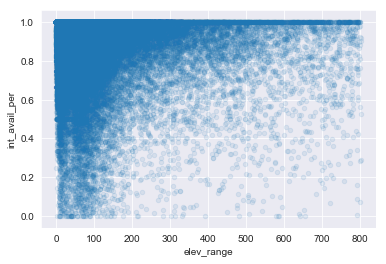

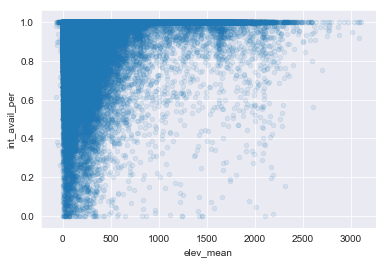

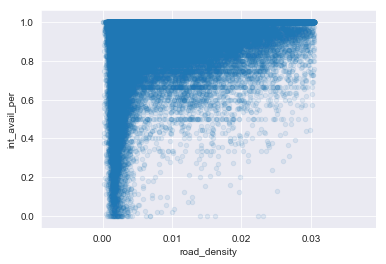

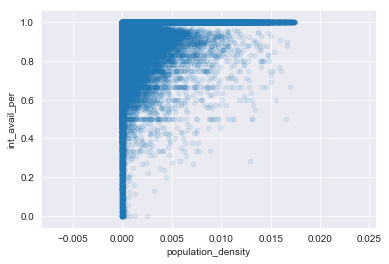

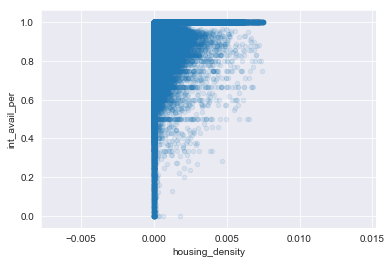

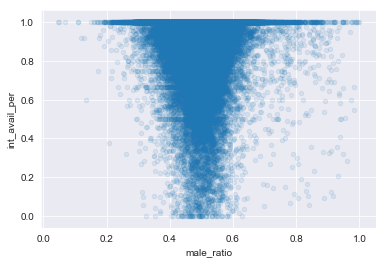

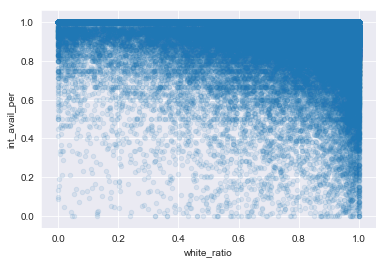

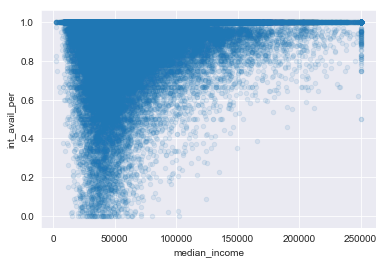

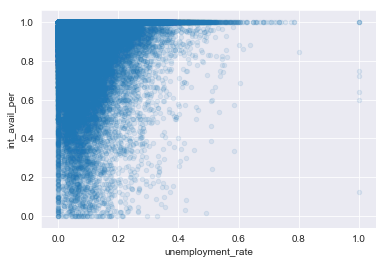

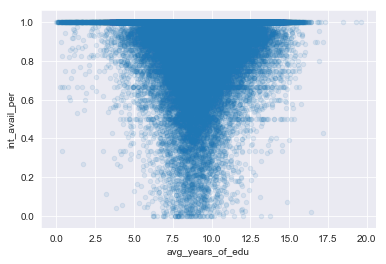

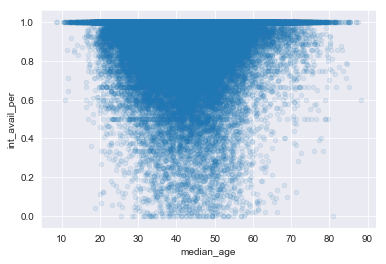

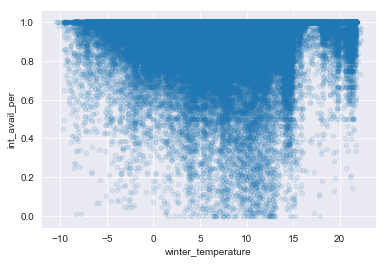

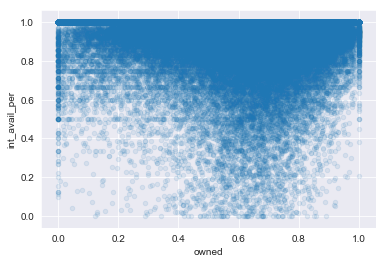

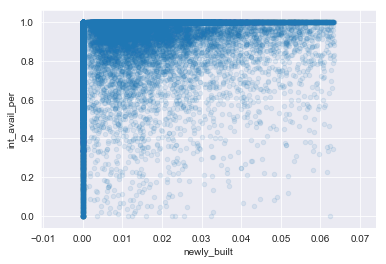

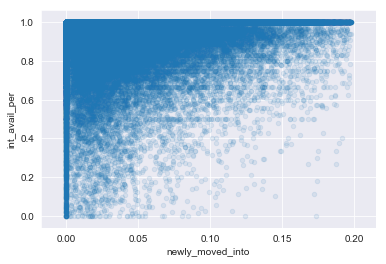

In [7]:
mask = ((data.elev_range < data.elev_range.quantile(0.99)) &
        (data.road_density < data.road_density.quantile(0.98)) &
        (data.population_density < data.population_density.quantile(0.98)) &
        (data.housing_density < data.housing_density.quantile(0.98)) &
        (data.newly_built < data.newly_built.quantile(0.99)) &
        (data.newly_moved_into < data.newly_moved_into.quantile(0.99)))
viz = data[mask]
viz.reset_index(inplace=True)

for col in viz.select_dtypes(include=[np.float]).columns[1:]:
    viz.plot(x=col, y='int_avail_per', kind='scatter', alpha=0.1)

Text(0.5,0,'Internet availability percentage')

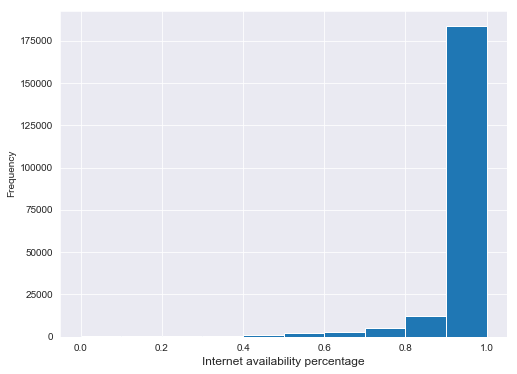

In [8]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [9]:
data.int_avail_per.describe()

count    209627.000000
mean          0.959622
std           0.111572
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [10]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', full_coverage)
print('block_group without full coverage', 100 - full_coverage)

block_group with full coverage 75.36958502482982
block_group without full coverage 24.630414975170183


# Correlation Analysis

Removing ethnicity & NA

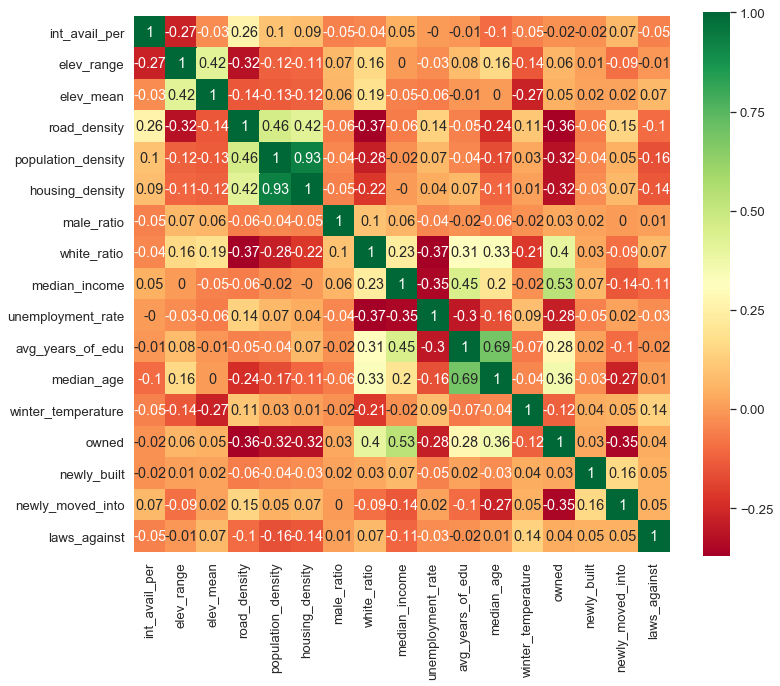

In [11]:
corr = data.corr().round(2)

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)
plt.show()

# Building a model

In [12]:
pd.options.mode.chained_assignment = None
data['is_full_coverage'] = (data['int_avail_per'] == 1)

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

target_col = 'is_full_coverage'
X = data.drop(columns=['int_avail_per', 'block_group', target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Balanced Model
balanced = RandomForestClassifier(max_depth=50, min_samples_split=20, n_estimators=10, class_weight='balanced')
balanced.fit(X_train, y_train)

print('Train Score:', balanced.score(X_train, y_train))
print('Test Score:', balanced.score(X_test, y_test))

params = {
    'min_samples_split': np.linspace(2, 8, 4, dtype = int),
    'max_depth': np.linspace(20, 50, 4, dtype = int),
}

grid_balanced = GridSearchCV(estimator=balanced, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
grid_balanced.fit(X_train, y_train)

print('Grid Searched Train Score:', grid_balanced.score(X_train, y_train))
print('Grid Searched Test Score:', grid_balanced.score(X_test, y_test))
print('Best Parameters:', grid_balanced.best_params_)

y_pred_balanced = grid_balanced.predict(X)
pd.crosstab(y, y_pred_balanced, rownames=['Actual'], colnames=['Predicted'])

Train Score: 0.9266730669465298
Test Score: 0.7969994752659447
Grid Searched Train Score: 0.9906263432485616
Grid Searched Test Score: 0.8771255091379858
Best Parameters: {'max_depth': 40, 'min_samples_split': 4}


Predicted,False,True
Actual,,
False,44568,7064
True,3428,154567


In [14]:
#Imbalanced Model
imbalanced = RandomForestClassifier(max_depth=50, min_samples_split=40, n_estimators=10)
imbalanced.fit(X_train, y_train)

print('Train score', imbalanced.score(X_train, y_train))
print('Test score', imbalanced.score(X_test, y_test))

params = {
    'min_samples_split': np.linspace(60, 90, 4, dtype = int),
    'max_depth': np.linspace(40, 70, 4, dtype = int),
}

grid_imbalanced = GridSearchCV(estimator=imbalanced, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
grid_imbalanced.fit(X_train, y_train)

print('Train score', grid_imbalanced.score(X_train, y_train))
print('Test score', grid_imbalanced.score(X_test, y_test))
print('Best Parameters:', grid_imbalanced.best_params_)

y_pred_imbalanced = grid_imbalanced.predict(X)
pd.crosstab(y, y_pred_imbalanced, rownames=['Actual'], colnames=['Predicted'])

Train score 0.877645333063011
Test score 0.8112388494013262
Train score 0.9046647514607821
Test score 0.8818838848405209
Best Parameters: {'max_depth': 40, 'min_samples_split': 80}


Predicted,False,True
Actual,,
False,26159,25473
True,7857,150138


# Finding important features.

In [15]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_balanced.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients.sort_values('gini_coef', ascending=False)

,feature,gini_coef
4,housing_density,0.115559
11,winter_temperature,0.113747
3,population_density,0.112898
0,elev_range,0.102561
1,elev_mean,0.093627
2,road_density,0.068088
6,white_ratio,0.054701
7,median_income,0.050658
10,median_age,0.048300
12,owned,0.047224


# Predicting the areas that is most likely to have full coverage

In [16]:
no_full_coverage = data[~data.is_full_coverage].copy()

X_pred = no_full_coverage.drop(columns=['int_avail_per', 'block_group', target_col])
proba = grid_balanced.predict_proba(X_pred)
no_full_coverage['proba'] = proba[:, 1]

### Among the blocks that do not currently have coverage (less than 50% coverage), what are the blocks that are likely to have coverage?

In [17]:
no_coverage = no_full_coverage[no_full_coverage.int_avail_per < 0.5]
no_coverage.sort_values('proba', ascending=False)[['block_group', 'proba', 'int_avail_per']].head(10)

,block_group,proba,int_avail_per
118638,260050307032,1.000000,0.380952
133715,060590320471,1.000000,0.250000
126407,040130506082,1.000000,0.386364
213111,060730191013,1.000000,0.417391
40270,517600706014,0.924663,0.333333
104373,131210094033,0.924663,0.272727
77112,060730132062,0.900000,0.416667
10015,510010906001,0.900000,0.000000
45935,060730202102,0.900000,0.428571
21261,401091066023,0.900000,0.400000
